In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, sum
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b2b5e9b6d3fb07191c1babe6d1dbb498cc7741aaecce97e29c5cdcb41b28e82f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
#Create a spark session
spark = SparkSession.builder.appName("BookRecommendation").config("spark.executor.memory", "4g").getOrCreate()

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load your book review dataset from Google Drive into a Spark DataFrame
file_path = '/content/drive/My Drive/603_project/Books_rating.csv'
df = spark.read.csv(file_path, header=True)

In [5]:
df.show(10)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|"If people become...|
|0826414346|Dr. Seuss: Ameri

In [6]:
# Number of rows
num_rows = df.count()
print(f"Number of rows: {num_rows}")

# Number of columns
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 3000000
Number of columns: 10


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Find and count duplicate rows
duplicate_rows = df.groupBy(*df.columns).count().where(col("count") > 1)
num_duplicate_rows = duplicate_rows.count()

print(f"Number of duplicate rows: {num_duplicate_rows}")


Number of duplicate rows: 7793


In [8]:
# Remove duplicate rows
df.dropDuplicates()

DataFrame[Id: string, Title: string, Price: string, User_id: string, profileName: string, review/helpfulness: string, review/score: string, review/time: string, review/summary: string, review/text: string]

In [9]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [10]:
# Calculate the count of null values in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the count of null values for each column
null_counts.show()

+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|  Price|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|  208|2517579| 562250|     562200|               367|         130|         27|            65|         43|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [11]:
# Summary statistics for 'Price' column
df.select('Price').describe().show()

+-------+--------------------+
|summary|               Price|
+-------+--------------------+
|  count|              482421|
|   mean|  21.767951161877054|
| stddev|   26.21155241772817|
|    min|              "" and|
|    max|: A guide to loca...|
+-------+--------------------+



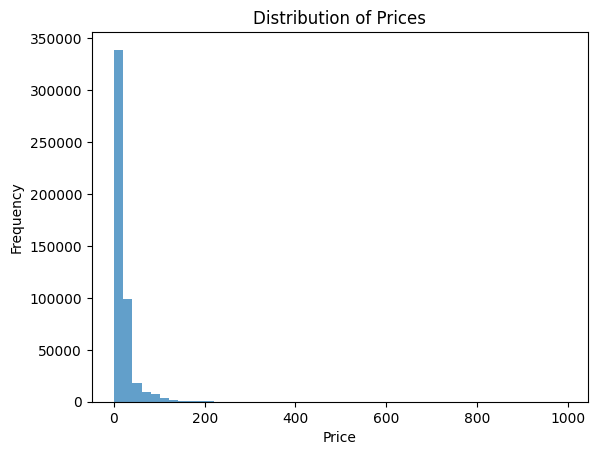

In [12]:
import matplotlib.pyplot as plt

df = df.withColumn('Price', col('Price').cast('double'))
# Extract 'Price' column to Pandas for plotting
price_data = df.select('Price').toPandas()

# Plotting a histogram
plt.hist(price_data['Price'], bins=50, alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()

In [13]:
from pyspark.sql.functions import corr
# Check correlation between 'Price' and 'review/score' columns
df.select(corr('Price', 'review/score')).show()

+-------------------------+
|corr(Price, review/score)|
+-------------------------+
|     -0.00989842862174...|
+-------------------------+



In [14]:
df= df.drop('Price')

In [15]:
df.show(10)

+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|"If people become...|
|0826414346|Dr. Seuss: Americ...|A2MVUWT453QH61|"Roy E. Perry ""

In [16]:
null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|  208| 562250|     562200|               367|         130|         27|            65|         43|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [17]:
# Assuming 'data' is your DataFrame
df = df.na.drop()

# Display the count of rows after dropping null values
print("Count of rows after dropping null values:", df.count())

Count of rows after dropping null values: 2436856


In [18]:
null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|    0|      0|          0|                 0|           0|          0|             0|          0|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [19]:
df.show(10)

+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|"If people become...|
|0826414346|Dr. Seuss: Americ...|A2MVUWT453QH61|"Roy E. Perry ""

In [20]:
# Convert necessary columns to numerical values
df = df.withColumn("Id", col("Id").cast("int"))
df = df.withColumn("review/score", col("review/score").cast("float"))

In [21]:
from pyspark.sql.functions import regexp_replace, col
#Clean text in the 'review/summary' column
df = df.withColumn("review/summary_cleaned", regexp_replace(col("review/summary"), '[^a-zA-Z0-9\s]', ''))
# Clean text in the 'review/text' column
df = df.withColumn("review/text_cleaned", regexp_replace(col("review/text"), '[^a-zA-Z0-9\s]', ''))

In [22]:
df.show(10)

+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|review/summary_cleaned| review/text_cleaned|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|  Nice collection o...|This is only for ...|
| 826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|     Really Enjoyed It|I dont care much ...|


In [23]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- review/summary_cleaned: string (nullable = true)
 |-- review/text_cleaned: string (nullable = true)



In [24]:
# Display summary statistics for 'review/score' column
df.select('review/score').summary().show()

+-------+-----------------+
|summary|     review/score|
+-------+-----------------+
|  count|          2420132|
|   mean|539.5573511072997|
| stddev|832799.9378566748|
|    min|              1.0|
|    25%|              4.0|
|    50%|              5.0|
|    75%|              5.0|
|    max|       1.295568E9|
+-------+-----------------+



In [25]:
distinct_review_scores = df.select('review/score').distinct()

# Show distinct review scores
distinct_review_scores.show()

+------------+
|review/score|
+------------+
|         5.0|
|         2.0|
|       327.0|
|       19.95|
|  1.295568E9|
|        NULL|
|         3.0|
|         1.0|
|         4.0|
+------------+



In [26]:
# Filter the DataFrame to keep rows with review scores between 1 and 5
df = df.filter((col('review/score') >= 1.0) & (col('review/score') <= 5.0))

# Show the filtered DataFrame
df.show()

+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|review/summary_cleaned| review/text_cleaned|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|  Nice collection o...|This is only for ...|
| 826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|     Really Enjoyed It|I dont care much ...|


In [27]:
row_count = df.count()
print("Row count of the DataFrame:", row_count)

Row count of the DataFrame: 2420111


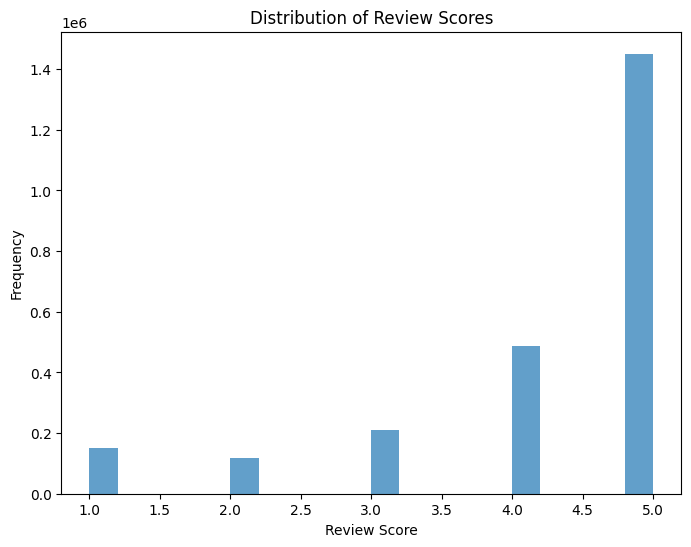

In [28]:
import matplotlib.pyplot as plt
# Visualize outliers using a box plot
score_data = df.select('review/score').toPandas()
# Visualize 'review/score' distribution using a histogram
plt.figure(figsize=(8, 6))
plt.hist(score_data['review/score'], bins=20, alpha=0.7)
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.show()

In [29]:
null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+-------+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+
|     Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|review/summary_cleaned|review/text_cleaned|
+-------+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+
|1371151|    0|      0|          0|                 0|           0|          0|             0|          0|                     0|                  0|
+-------+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+



In [30]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import random

# Filter out rows with non-null 'Id' values to create a DataFrame containing only non-null values
df_non_null = df.filter(df['Id'].isNotNull())

# Create a Window partitioned by 'Title' to generate a unique row number within each partition
window_title = Window.partitionBy('Title').orderBy(F.lit(1))

# Create a unique 'Id' for each book title by generating random 6-digit values
df_non_null = df_non_null.withColumn('new_id', F.when(F.col('Id').isNull(), F.floor(F.rand() * 900000 + 100000)).otherwise(F.col('Id')))
df_non_null = df_non_null.withColumn('row_num', F.row_number().over(window_title))

# Collect the mapping of 'Title' to 'new_id' into a dictionary
title_to_id = df_non_null.select('Title', 'new_id').distinct().rdd.collectAsMap()

# Broadcast the dictionary to all nodes
broadcasted_title_to_id = spark.sparkContext.broadcast(title_to_id)

# Function to replace null 'Id' values with a randomly generated 6-digit ID
def fill_null_id(title, current_id):
    if current_id is None:
        return broadcasted_title_to_id.value.get(title, random.randint(100000, 999999))
    else:
        return current_id

# Define the UDF
fill_null_id_udf = F.udf(fill_null_id)

# Apply the function to fill null 'Id' values in the DataFrame
df_filled = df.withColumn('Id', fill_null_id_udf(F.col('Title'), F.col('Id')))

# Show the resulting DataFrame
df_filled.show()


+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|review/summary_cleaned| review/text_cleaned|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|  Nice collection o...|This is only for ...|
| 826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|     Really Enjoyed It|I dont care much ...|


In [31]:
null_counts = df_filled.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_filled.columns])
null_counts.show()

+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+
| Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|review/summary_cleaned|review/text_cleaned|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+
|  0|    0|      0|          0|                 0|           0|          0|             0|          0|                     0|                  0|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+



In [32]:
import hashlib
from pyspark.sql import functions as F

def hash_user_id(user_id):
    return int(hashlib.sha256(user_id.encode('utf-8')).hexdigest(), 16) % 10**8  # Hash to limit range

# Define a User Defined Function (UDF) to apply the hash function to the DataFrame's user ID column
hash_user_id_udf = F.udf(hash_user_id)

# Apply the hash function to your DataFrame's user ID column
df = df_filled.withColumn("user_id_hashed", hash_user_id_udf(F.col("User_id")))

In [33]:
df.show(10)

+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+--------------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|review/summary_cleaned| review/text_cleaned|user_id_hashed|
+----------+--------------------+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+----------------------+--------------------+--------------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|  Nice collection o...|This is only for ...|      89616962|
| 826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don'

In [34]:
null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
null_counts.show()

+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+--------------+
| Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|review/summary_cleaned|review/text_cleaned|user_id_hashed|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+--------------+
|  0|    0|      0|          0|                 0|           0|          0|             0|          0|                     0|                  0|             0|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+----------------------+-------------------+--------------+



In [35]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- review/summary_cleaned: string (nullable = true)
 |-- review/text_cleaned: string (nullable = true)
 |-- user_id_hashed: string (nullable = true)



In [36]:
df = df.withColumn("user_id_hashed", col("user_id_hashed").cast("int"))
df = df.withColumn("Id", col("Id").cast("int"))

In [37]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- review/summary_cleaned: string (nullable = true)
 |-- review/text_cleaned: string (nullable = true)
 |-- user_id_hashed: integer (nullable = true)



In [38]:
# Split the data into training and test sets
(training, test) = df.randomSplit([0.8, 0.2])

In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler

In [40]:
df = df.withColumnRenamed("user_id_hashed", "user").withColumnRenamed("Id", "item").withColumnRenamed("review/score", "rating")

In [41]:
# Split the data into training and test sets
(training, test) = df.randomSplit([0.8, 0.2])

In [42]:
# Create a feature vector assembler
feature_assembler = VectorAssembler(inputCols=["user", "item"], outputCol="features")

In [43]:
# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

In [44]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(featuresCol="scaled_features", labelCol="rating", numTrees=10)

In [45]:
# Create a pipeline
pipeline = Pipeline(stages=[feature_assembler, scaler, rf_model])

In [46]:
# Fit the pipeline to the training data
model = pipeline.fit(training)

In [47]:
# Make predictions on the test set
predictions = model.transform(test)

In [48]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Random Forest Model RMSE:", rmse)


Random Forest Model RMSE: 1.1801499064861372


In [49]:
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = evaluator_mae.evaluate(predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.925103634370906


In [50]:
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="rating", predictionCol="prediction")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2):", r2)

R-squared (R2): 0.0011760363644339744


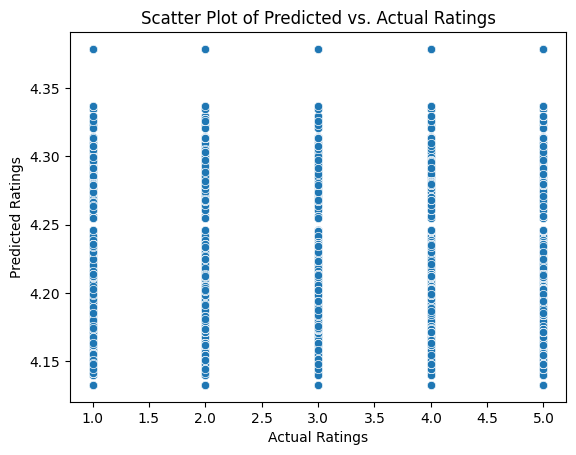

In [52]:
import seaborn as sns
# Assuming 'predictions' DataFrame contains 'prediction' and 'rating' columns
predictions_pd = predictions.select('prediction', 'rating').toPandas()
sns.scatterplot(x='rating', y='prediction', data=predictions_pd)
plt.title('Scatter Plot of Predicted vs. Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [53]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression

In [54]:
# Create a GBT Regressor model
gbt_model = GBTRegressor(featuresCol="scaled_features", labelCol="rating", maxIter=10)

In [55]:
# Create a pipeline
pipeline_gbt = Pipeline(stages=[feature_assembler, scaler, gbt_model])

In [56]:
# Fit the pipeline to the training data
model_gbt = pipeline_gbt.fit(training)

In [57]:
# Make predictions on the test set
predictions_gbt = model_gbt.transform(test)

In [61]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse_gbt = evaluator.evaluate(predictions_gbt)
print("GBT Model RMSE:", rmse_gbt)

GBT Model RMSE: 1.1780218528298354


In [59]:
# Additional Evaluation Metrics
mae_gbt = evaluator_mae.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)
print("GBT Model MAE:", mae_gbt)
print("GBT Model R-squared (R2):", r2_gbt)

GBT Model MAE: 0.9230983501204993
GBT Model R-squared (R2): 0.0013946922769509928


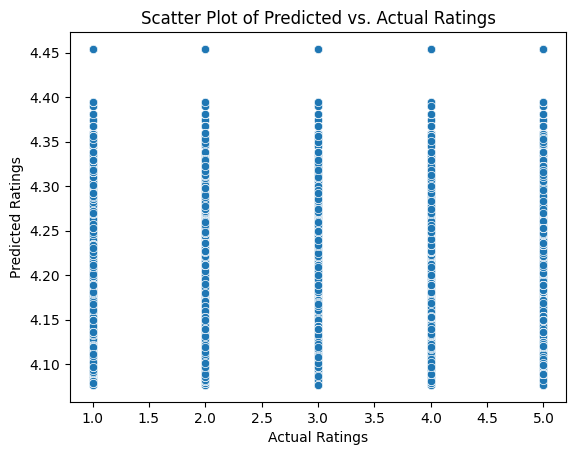

In [62]:
import seaborn as sns
# Assuming 'predictions' DataFrame contains 'prediction' and 'rating' columns
predictions_pd2 = predictions_gbt.select('prediction', 'rating').toPandas()
sns.scatterplot(x='rating', y='prediction', data=predictions_pd2)
plt.title('Scatter Plot of Predicted vs. Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [63]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [64]:
# Tokenize the review text
tokenizer = Tokenizer(inputCol="review/text_cleaned", outputCol="words")

In [65]:
# Apply HashingTF to convert words into feature vectors
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)

In [66]:
# Apply IDF to scale the features
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [67]:
# Create a Linear Regression model
lr_model = LinearRegression(featuresCol="features", labelCol="rating")

In [68]:
# Create a pipeline
pipeline_content_based = Pipeline(stages=[tokenizer, hashingTF, idf, lr_model])

In [69]:
# Fit the pipeline to the training data
model_content_based = pipeline_content_based.fit(training)

In [70]:
# Make predictions on the test set
predictions_content_based = model_content_based.transform(test)

In [71]:
# Evaluate the model using RMSE
evaluator_content_based = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse_content_based = evaluator_content_based.evaluate(predictions_content_based)
print("Content-Based Model RMSE:", rmse_content_based)

# Additional Evaluation Metrics
mae_content_based = evaluator_mae.evaluate(predictions_content_based)
r2_content_based = evaluator_r2.evaluate(predictions_content_based)
print("Content-Based Model MAE:", mae_content_based)
print("Content-Based Model R-squared (R2):", r2_content_based)

Content-Based Model RMSE: 1.0635011222333108
Content-Based Model MAE: 0.813172554736294
Content-Based Model R-squared (R2): 0.18544126860017118


In [73]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Create a Window specification to partition by user_id and order by predicted rating in descending order
windowSpec = Window.partitionBy("User_id").orderBy(predictions["prediction"].desc())

# Add a row number to each row within the window
top5_predictions = predictions.withColumn("row_number", row_number().over(windowSpec))

# Filter only the top 5 recommendations for each user
top5_recommendations = top5_predictions.filter("row_number <= 5")

# Show the top 5 recommendations
top5_recommendations.select("user", "item", "prediction").show()

+--------+----------+------------------+
|    user|      item|        prediction|
+--------+----------+------------------+
|77946310|    304229| 4.224250942076533|
|35898497|    724651| 4.228036397607806|
|94033535|    602921| 4.222012947346929|
|85588511|    821209| 4.222649658654644|
|48767368|    568050|  4.23712661581348|
|48767368|    714122|  4.23712661581348|
|81198952|    390072| 4.223007708731133|
|11186830| 385187157| 4.205536410269363|
|91588792| 894714805|4.2736880631403205|
|91588792|    846947| 4.222649658654644|
|91588792|1582790337| 4.217520583926932|
|91588792|1569602093| 4.217520583926932|
|91588792|1582790337| 4.217520583926932|
|94476280|1929229488|4.2711779663379215|
|71272400|    978943| 4.221477881754154|
|71272400|    694965| 4.221477881754154|
|71272400|    847752| 4.221477881754154|
|71272400|    805004| 4.221477881754154|
|71272400|    141269| 4.220841170446439|
|82428746| 783552661| 4.144256027697223|
+--------+----------+------------------+
only showing top

In [74]:
spark.stop()